## Resnet50 Focal Loss Experiment (no reweight)

In [1]:
import os
import sys
import yaml
import wandb
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn.functional as F
import time
from torch.utils.data import DataLoader

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
%pip install wandb -qU
%matplotlib inline

# Get the current working directory
notebook_dir = notebook_dir = os.path.dirname(os.path.abspath("__file__"))  
project_dir = os.path.abspath(os.path.join(notebook_dir, '..')) 
if project_dir not in sys.path:
    sys.path.append(project_dir)

from src import (get_transforms, load_data, split_data, set_seeds, 
                 verify_splits, verify_data, plot_species_grid,
                 verify_loader_transforms)
from src.data_utils import ImagesDataset
from src.models import build_resnet50_basic
from src.train import setup_training, evaluate_low_log, train

Note: you may need to restart the kernel to use updated packages.


Ensure your directory is set up properly:

In [2]:
# !tree ../ -L 2


In [3]:
# !tree ../data/ -L 2

### **Set up your experiment**

Copy this notebook. Rename it, but keep it in `notebooks/`. To update any settings, params, and/or hyperparams make a copy of `configs/default.yaml`, rename it and call your new `.yaml` below. Be sure to keep it in `configs/`

In [4]:
# Locate the YAML file relative to the notebook's location
notebook_dir = os.path.dirname(os.path.abspath("__file__"))

# You need to update this path to your new .yaml file
config_path = os.path.join(notebook_dir, "../configs/res_focal.yaml")

# Load the YAML file
with open(config_path, "r") as f:
    config = yaml.safe_load(f)
# print(config)

In [5]:
print(torch.__version__)
print(torch.backends.mps.is_available())
device = config["device"]
print(f"Running on device: {device}")

2.5.1
True
Running on device: mps


### **Build the datasets**

#### Load the data
Note: your data file should be hidden in the repo (.gitignore) but make sure to set it up locally like:

`wildlife/data/givens/test_features/[images...]`

`wildlife/data/givens/train_features/[images...]`

`wildlife/data/givens/train_features.csv`

`wildlife/data/givens/test_features.csv`

In [6]:

train_features, test_features, train_labels, species_labels = load_data()

#### Augment Data

In [7]:
# Get transforms
train_transforms, val_transforms = get_transforms(config)
# print(train_transforms)

#### Split into train and evaluation sets

We need to ensure that sites are mutually exclusive between the training and validation sets, meaning no site should appear in both sets. This ensures a proper stratification based on site.

In [8]:
set_seeds(config["experiment"]["seed"])
X_train, X_val, y_train, y_val = split_data(
    train_features, train_labels, type='sites')

In [9]:
# Helper function (Optional)
# verify_splits(X_train, y_train, X_val,  y_val)

#### Set up DataLoader

In [10]:
set_seeds(config["experiment"]["seed"])

# Create datasets
train_dataset = ImagesDataset(
    features=X_train, 
    labels=y_train, 
    transform=train_transforms, 
    device=device)
val_dataset = ImagesDataset(
    features=X_val, 
    labels=y_val, 
    transform=val_transforms, 
    device=device)

if device=="cuda":
    pin=False
else:
    pin=True

# Create DataLoaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=config["train"]["batch_size"], 
    shuffle=True, 
    pin_memory=pin)
val_loader = DataLoader(
    val_dataset, 
    batch_size=config["train"]["batch_size"], 
    shuffle=False, 
    pin_memory=pin)

In [11]:
# verify transformations in dataloaders (Optional)
# verify_loader_transforms(train_loader, title_type='train')
# verify_loader_transforms(val_loader, title_type='validate')

# set_seeds(config["experiment"]['seed'])

In [12]:
# Print shapes for verification (Optional)
# print(f"Training set: {len(train_dataset)} samples")
# print(f"Validation set: {len(val_dataset)} samples")

### **Training**


#### Define the model
Note: If you build a new model, add it to `models.py` and update the block below. And update your `.yaml` config.

In [13]:
set_seeds(config["experiment"]['seed'])
model =  build_resnet50_basic(
    num_classes = config["model"]["num_classes"],
    hidden_units1 = config["model"]["hidden_units1"],
    dropout = config["model"]["dropout"],
    freeze_backbone = config["model"]["freeze_backbone"]
)
model = model.to(device)

#### Define your criterion and optimizer
Note: If needed up date these in `train.py` and update your `.yaml` config.

In [14]:
set_seeds(config["experiment"]['seed'])
class_counts = y_train.sum(axis=0).values
# print(class_counts)

criterion, optimizer = setup_training(
        model, 
        criterion=config["train"]["criterion"],
        optimizer=config["train"]["optimizer"], 
        lr=config["train"]["lr"], 
        momentum=config["train"]["momentum"],
        gamma=config["train"]["gamma"],
        alpha=config["train"]["alpha"],
        device=device,
        cls_num_list=class_counts)
print(config["train"]["alpha"])
print(criterion)

None
FocalLoss()


#### Set up logging

In [15]:
wandb.require()
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: gball30 (gball30-georgia-institute-of-technology). Use `wandb login --relogin` to force relogin


True

In [16]:
# ✨ W&B: Initialize a new run to track this model's training
wandb.init(project="wildlife")
cfg = wandb.config
cfg.update(config)

#### Run the train / eval loop

In [17]:
train_losses = []  # To store average training loss per epoch
val_losses = []    # To store validation loss per epoch
set_seeds(config["experiment"]['seed'])

start_time = time.time()
for epoch in range(config["train"]["epochs"]):
    # Training step
    avg_train_loss = train(model, 
                                     train_loader, 
                                     criterion, 
                                     optimizer, 
                                     epoch, config, device=device)
    train_losses.append(avg_train_loss)  # Store avg training loss
    print(f"Epoch {epoch+1}/{config["train"]["epochs"]} - Avg Train Loss: {
        avg_train_loss:.12f}")
    
    # Evaluation step
    eval_metrics = evaluate_low_log(model, val_loader, criterion, config, epoch+1, device=device)
    val_losses.append(eval_metrics["loss"])  # Store validation loss
    print(f"Epoch {epoch+1}/{config["train"]["epochs"]} - Eval Loss: {
        eval_metrics['loss']:.12f}, Eval Acc: {eval_metrics['accuracy']:.2f}%")

end_time = time.time()
duration = end_time - start_time
wandb.log({"duration": duration})


Starting training for epoch 1
Epoch [1/5], Step [100/412], Loss: 1.381795644760
Epoch [1/5], Step [200/412], Loss: 1.199277400970
Epoch [1/5], Step [300/412], Loss: 1.016803264618
Epoch [1/5], Step [400/412], Loss: 0.981006145477
Epoch 1/5 - Avg Train Loss: 1.148034077102
Eval - Loss: 0.9374, Accuracy: 34.55%, Precision: 0.28, Recall: 0.35, F1: 0.27, MacroF1: 0.25
Epoch 1/5 - Eval Loss: 0.937421367146, Eval Acc: 34.55%
Starting training for epoch 2
Epoch [2/5], Step [100/412], Loss: 0.657710313797
Epoch [2/5], Step [200/412], Loss: 0.809814691544
Epoch [2/5], Step [300/412], Loss: 0.742990016937
Epoch [2/5], Step [400/412], Loss: 0.617784678936
Epoch 2/5 - Avg Train Loss: 0.746307136581
Eval - Loss: 0.8548, Accuracy: 38.77%, Precision: 0.40, Recall: 0.39, F1: 0.37, MacroF1: 0.37
Epoch 2/5 - Eval Loss: 0.854811105017, Eval Acc: 38.77%
Starting training for epoch 3
Epoch [3/5], Step [100/412], Loss: 0.595596611500
Epoch [3/5], Step [200/412], Loss: 0.414637744427
Epoch [3/5], Step [300/4

If you are done logging or you want to run the experiment again, finish with the block below. But if you think you might want to submit this run to the competition, don't finish logging until the end once you've added the competition score.

In [18]:
# ✨ W&B: Mark the run as complete (Or wait until the end of notebook)
wandb.finish()

duration,▁
epoch,▁▁▁▁▁▁▁▁▃▃▃▃▃▃▃▃▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆████████
eval_accuracy,▁▃▅▆█
eval_f1,▁▄▅▇█
eval_loss,█▆▂▂▁
eval_macro_f1,▁▄▆▇█
eval_precision,▁▄▆▇█
eval_recall,▁▃▅▆█
f1_antelope_duiker,▄▁▇▆█
f1_bird,▁▇▅██
f1_blank,▁▄▆▇█


---


### **Explore Experiment** 

In [19]:
# set to True to explore and potentially submit your results 
explore = True

#### Learning Curve

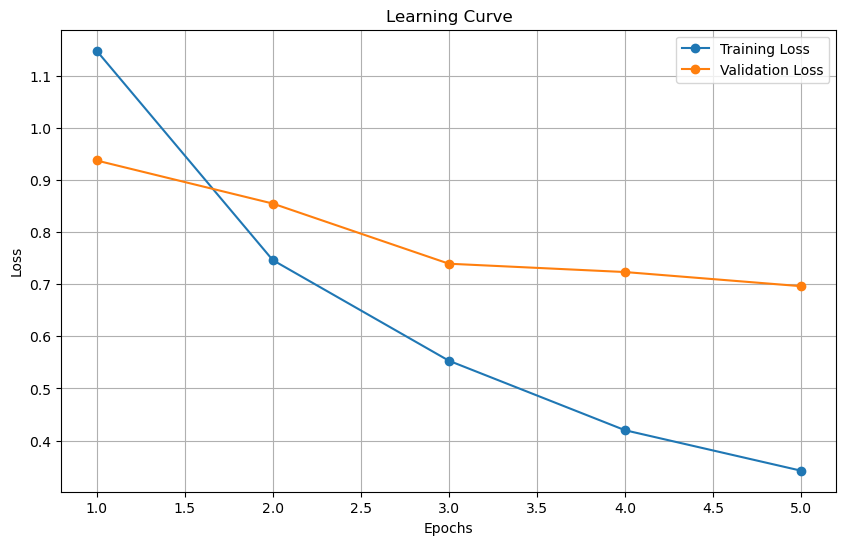

In [20]:
if explore:
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, config["train"]["epochs"]+1), train_losses, label="Training Loss", marker="o")
    plt.plot(range(1, config["train"]["epochs"]+1), val_losses, label="Validation Loss", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Learning Curve")
    plt.legend()
    plt.grid(True)
    plt.show()

#### Class Distribution  

True Labels from Training Set

In [21]:
if explore:
    print("True labels (training):")
    print(y_train.idxmax(axis=1).value_counts())   

True labels (training):
civet_genet         2055
monkey_prosimian    1959
antelope_duiker     1867
leopard             1859
blank               1800
rodent              1535
bird                1324
hog                  772
Name: count, dtype: int64


True and Predicated Labels from Validation Set